# Download and extract dataset

In [2]:
#@title Download a the dataset sample from Supervisely
!curl https://assets.supervisely.com/supervisely-supervisely-assets-public/teams_storage/W/6/pt/ANAGVgKaC62tTrDQWK5JhNP2dd8ynqaTKSM1QdVoAasmTdaLvBwCuW7nCrq9o9lLS2padKnV9QogVGFlEPg7vxEBPIfuFC2Yq7ELNW7xn2t1egLrQPoGpNFJobhh.tar --output mvtec.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  548M  100  548M    0     0  21.3M      0  0:00:25  0:00:25 --:--:-- 21.6M


In [3]:
#@title Extract the tarball 'mvtec.tar' and look for test images for the hazelnut subset
!tar -xf mvtec.tar
!ls test/img/hazelnut_*

tar: Removing leading `/' from member names
test/img/hazelnut_crack_002.png  test/img/hazelnut_print_004.png
test/img/hazelnut_cut_003.png	 test/img/hazelnut_print_005.png
test/img/hazelnut_good_023.png	 test/img/hazelnut_print_006.png
test/img/hazelnut_good_037.png	 test/img/hazelnut_print_007.png
test/img/hazelnut_hole_005.png	 test/img/hazelnut_print_009.png
test/img/hazelnut_hole_010.png	 test/img/hazelnut_print_011.png
test/img/hazelnut_hole_013.png	 test/img/hazelnut_print_012.png
test/img/hazelnut_hole_016.png	 test/img/hazelnut_print_013.png
test/img/hazelnut_print_003.png  test/img/hazelnut_print_016.png


# Clone the repo

This is the repo to clone:

https://github.com/akridata-ai/ZS-CLIP-AC-naive

In [4]:
#@title  Clone the Git repo here, in the Colab runtime
!git clone https://github.com/akridata-ai/ZS-CLIP-AC-naive.git

Cloning into 'ZS-CLIP-AC-naive'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), done.
Resolving deltas: 100% (2/2), done.


In [5]:
#@title Configure git user
!git config --global user.email "preethshivani99@gmail.com"
!git config --global user.name "PreethShivani"

In [6]:
#@title Move to the repo for subsequent work
%cd /content/ZS-CLIP-AC-naive

!git branch -a

/content/ZS-CLIP-AC-naive
* main
  remotes/origin/HEAD -> origin/main
  remotes/origin/feature/template-code
  remotes/origin/main


In [8]:
# Going to the Feature feature/template-code branch
!git checkout -b feature/template-code origin/feature/template-code

Branch 'feature/template-code' set up to track remote branch 'feature/template-code' from 'origin'.
Switched to a new branch 'feature/template-code'


In [9]:
!git branch -vv

* feature/template-code c9d8665 [origin/feature/template-code] Update README.md to fix 'References'
  main                  d6c1daf [origin/main] Basic project structure.


In [10]:
#@title Verify that the files appear here
!ls

clip_ac.py  data  README.md  requirements.txt  spec.py


In [11]:
#@title Move images for the hazelnut subset from the test split to the `data` folder in the repository
!cp /content/test/img/hazelnut_* data/

In [12]:
#@title Install the requirements from the `requirements.txt` file
!pip install -qr requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00


In [13]:
#@title Modify `spec.py` and save its contents
%%writefile spec.py
"""
Spec containing the configuration for the defect classification task
"""
from pydantic import BaseModel


class DefectClassificationSpec(BaseModel):
    """
    Configuration for defect classification.

    Attributes:
        class_names: List[str]; The list of class names (normal, defect categories).
        prompts: List[str]; The list of prompts corresponding to the class names.
        model_name (str): Name of the CLIP model variant to use.
    """
    # Define attributes here with appropriate types and default values if any.
    model_name: str = "ViT-B/32"
    class_names: list[str] = ["good","crack", "cut", "hole", "print"]
    prompts: list[list[str]] = [
    # good
    ["A perfect hazelnut with smooth unblemished shell",
     "A flawless hazelnut with natural brown surface",
     "A pristine nut showing no defects or damage",
     "hazelnut with perfect brown shell surface no holes cracks cuts",
     "brown hazelnut showing flawless natural texture not damaged",
    ],

    # crack
    [
        "A photo of a hazelnut with a visible crack on its shell",
        "A hazelnut with a broken shell",
        "A fractured hazelnut shell",
        "A damaged hazelnut with cracks running across the surface"
    ],

    # cut
    [
        "A hazelnut with a straight cut through the shell",
        "A hazelnut with a linear split or division",
        "A nut showing clean cut lines or separations",
        "hazelnut with straight cut line through brown shell no surface stains",
        "brown hazelnut showing linear cut separation not ink marks",
        "whole hazelnut with clean cut division no printing defects"
    ],

    # hole
    [
        "A hazelnut with a round hole in the shell and a crack running across the shell",
        "A hazelnut with a circular opening or cavity",
        "A nut showing drilled holes or puncture marks that is combined with a visible crack",
        "hazelnut with small round hole opening through brown shell no surface stains",
        "brown hazelnut shell showing circular cavity puncture not ink marks",
        "whole hazelnut with drilled opening hole damage no printing defects"
    ],

    # print
    [
        "A hazelnut with an abnormal surface mark",
        "A hazelnut with a print-like defect or stain",
        "A nut showing unwanted imprints or irregular patterns",
        "hazelnut with ink stain printing mark surface discoloration no cracks",
        "hazelnut shell showing pressed imprint stamp pattern not cut",
        "whole hazelnut with colored marking surface stain blotch no sharp edges"
    ]
]


Overwriting spec.py


In [14]:
#@title  Modify `clip_ac.py` and save its contents
%%writefile clip_ac.py
"""
Zero-shot defect classification using CLIP
"""

import clip
import torch
from PIL import Image
from pathlib import Path
from typing import List, Tuple
from collections import Counter
from spec import DefectClassificationSpec
import torchvision.transforms as T

def classify_defects(test_dir, spec, return_paths=False):
    """
    Zero-shot defect classification using CLIP.

    Args:
        spec: Pydantic spec containing prompts and model name.
        test_dir: Path to the test dataset root.
                For this task, we expect filenames to indicate the ground-truth label.
                E.g. `hazelnut_print_*.png` indicates an image with the 'print' defect class.
                There are a few other kinds of defects too; find these from the file names.
                `hazelnut_good_*.png` indicates an image of the good/normal class.

    Returns:
        y_true: list of ground-truth labels
        y_pred: list of predicted labels
    """
    # Load model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)

    #  Load images and labels from test_dir
    test_dir = Path(test_dir)

    # Restricting to hazelnut subset only
    img_paths = sorted(test_dir.glob("hazelnut_*.png"))

    images = []
    labels = []
    file_paths = []
    valid_labels = set(spec.class_names)

    for img_path in img_paths:
        # Extract label robustly: pick the token that matches one of the known class names
        parts = img_path.stem.split("_")
        label = next((t for t in parts if t in valid_labels), None)
        if label is None:
           continue  # skip files that don’t match our labels

        img = Image.open(img_path).convert("RGB")
        images.append(preprocess(img).unsqueeze(0))
        labels.append(label)
        file_paths.append(str(img_path))

    # To see how many per true label
    print("Counts per true label:", Counter(labels))

    #  Encode text prompts for all the classes
    text_features = []
    with torch.no_grad():
        for prompts in spec.prompts:
            tokens = clip.tokenize(prompts).to(device)
            encodings = model.encode_text(tokens)
            encodings = encodings / encodings.norm(dim=-1, keepdim=True)
            mean_encoding = encodings.mean(dim=0)
            mean_encoding = mean_encoding / mean_encoding.norm()
            text_features.append(mean_encoding)

    text_features = torch.stack(text_features).to(device)

    #  Compare image features to text features, choose predicted label
    y_true = []
    y_pred = []

    with torch.no_grad():
        for img, label in zip(images, labels):
            img = img.to(device)

            # 1. Encode image → feature vector
            image_features = model.encode_image(img)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # 2. Compute similarity with all text features
            similarity = (image_features @ text_features.T)  # shape: [1, num_classes]

            # 3. Pick the class with highest similarity
            pred_idx = similarity.argmax(dim=-1).item()
            pred_label = spec.class_names[pred_idx]

            # 4. Collect results
            y_true.append(label)
            y_pred.append(pred_label)

    #  Return lists y_true and y_pred
    if return_paths:
        return  y_true,y_pred, file_paths
    else:
        return  y_true,y_pred



Overwriting clip_ac.py


In [15]:
#@title  Run the defect classification code
from pathlib import Path
from spec import DefectClassificationSpec
from clip_ac import classify_defects

# Create the spec for the 'hazelnut' subset
defect_spec = DefectClassificationSpec()

test_dir = Path("data")
y_pred, y_true, file_paths = classify_defects(test_dir, defect_spec, return_paths=True)

for path, true_label, pred_label in zip(file_paths, y_true, y_pred):
    print(f"Image: {Path(path).name} | True: {true_label} | Predicted: {pred_label}")

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 39.0MiB/s]


Counts per true label: Counter({'print': 10, 'hole': 4, 'good': 2, 'crack': 1, 'cut': 1})
Image: hazelnut_crack_002.png | True: crack | Predicted: crack
Image: hazelnut_cut_003.png | True: print | Predicted: cut
Image: hazelnut_good_023.png | True: good | Predicted: good
Image: hazelnut_good_037.png | True: hole | Predicted: good
Image: hazelnut_hole_005.png | True: hole | Predicted: hole
Image: hazelnut_hole_010.png | True: crack | Predicted: hole
Image: hazelnut_hole_013.png | True: crack | Predicted: hole
Image: hazelnut_hole_016.png | True: hole | Predicted: hole
Image: hazelnut_print_003.png | True: print | Predicted: print
Image: hazelnut_print_004.png | True: print | Predicted: print
Image: hazelnut_print_005.png | True: print | Predicted: print
Image: hazelnut_print_006.png | True: print | Predicted: print
Image: hazelnut_print_007.png | True: print | Predicted: print
Image: hazelnut_print_009.png | True: print | Predicted: print
Image: hazelnut_print_011.png | True: print | Pr

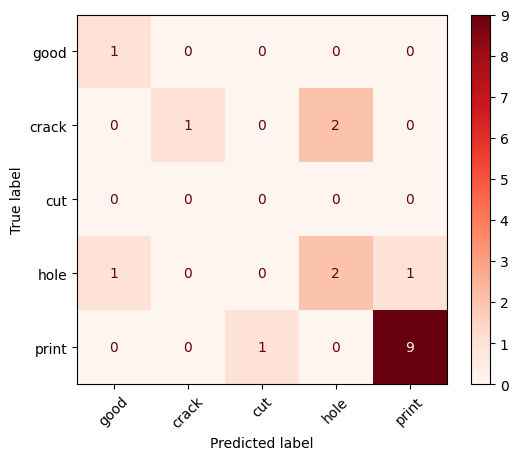

In [16]:
#@title TO DO: Print the confusion matrix using the predictions and ground truth labels

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=defect_spec.class_names)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=defect_spec.class_names)
disp.plot(cmap=plt.cm.Reds)
plt.xticks(rotation=45)
plt.show()


##  With a different spec

In [17]:
from spec import DefectClassificationSpec

# New spec with simpler and shorter prompts
defect_spec_v2 = DefectClassificationSpec(
    model_name="ViT-B/16",   # Trying out a different model
    class_names=["good", "crack", "cut", "hole", "print"],
   prompts=[
        ["A photo of a good hazelnut"],
        ["A photo of a hazelnut with a crack"],
        ["A photo of a hazelnut with a cut"],
        ["A photo of a hazelnut with a hole"],
        ["A photo of a hazelnut with a print defect"]
    ]
)


100%|███████████████████████████████████████| 335M/335M [00:11<00:00, 30.6MiB/s]


Counts per true label: Counter({'print': 10, 'hole': 4, 'good': 2, 'crack': 1, 'cut': 1})


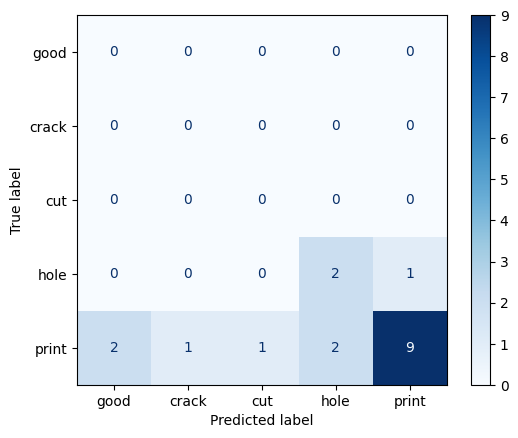

In [18]:
#Confusion matrix for the new spec
y_pred, y_true, file_paths = classify_defects(test_dir, defect_spec_v2, return_paths=True)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=defect_spec_v2.class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=defect_spec_v2.class_names)
disp.plot(cmap="Blues")
plt.show()




##**Observations – Confusion Matrix**##

I analyzed the confusion matrix to understand class-level performance. **For example, “good” images were sometimes misclassified as “hole,” “hole” images were often misclassified as “crack,” and “cut” samples as “print.” In contrast, “print” had the strongest performance, being mostly classified correctly.** This highlights that the model struggles with subtle defect differences, a limitation amplified by the small dataset size.

## **Experimentation with Prompts and Augmentation**##

In the first specification, I used the **ViT-B/32** model, and in the second specification, I switched to the **ViT-B/16 model along with shorter and refined prompts.** However, this change did not significantly improve classification accuracy. I also attempted **image augmentation techniques, such as positional shifts and transformations**, though the code is not included here. Despite these efforts, the misclassification patterns largely remained unchanged.
## **Iterative Prompt Adjustment**##

I further examined which images were misclassified and iteratively adjusted the prompts in response. However, this approach also failed to resolve the issue, again due to the **limited number of images per class**, which restricted the model’s ability to generalize effectively.

##**Conclusion**##

From these experiments, I observed that while WinCLIP provides a strong foundation for zero-shot classification, it faces challenges in fine-grained industrial defect detection when datasets are small. **Misclassifications persisted despite prompt engineering and image augmentation.** To achieve robust performance, the approach requires larger datasets, targeted fine-tuning, or complementary methods beyond zero-shot prompting alone.
